In [1]:
%%capture
%load_ext autoreload
%autoreload 2

In [3]:
# region General Imports
import os
import uuid
import re
import sys
import shutil
import time
import random
import datetime
import glob
import pickle
import tqdm
import copy
import optuna
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import mne
from rich import print as rprint
from rich.pretty import pprint as rpprint
from tqdm import tqdm
from itertools import chain
from functools import partial
# endregion General Imports

from model_optim.model_optimizer import ModelOptimizer
from model_optim.utils import channels_to_channels_idx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dataset
from custom_datasets.fatigue_mi import FatigueMI
from custom_datasets.norm_cho import NormCho2017
from custom_datasets.opt_game_mi import OptGameMI
from custom_datasets.opt_std_mi import OptStdMI

tf.random.set_seed(42)
np.random.seed(42)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


/home/arazzz/anaconda3/envs/moabb_model_optimization_quant/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [4]:
# region Helper funcs
def shallow_conv_net_square_layer(x):
    return tf.math.square(x)

def shallow_conv_net_log_layer(x):
    return tf.math.log(tf.clip_by_value(x, 1e-7, 10000))

CUSTOM_OBJECTS = {
    "shallow_conv_net_square_layer": shallow_conv_net_square_layer, 
    "shallow_conv_net_log_layer": shallow_conv_net_log_layer 
}
# endregion Helper funcs

# region Models
def shallow_conv_net(
    nb_classes, channels, samples, **kwargs
):
    """
    From: https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """

    _POOL_SIZE_D2_ = kwargs.get("pool_size_d2", 35)
    _STRIDES_D2_ = kwargs.get("strides_d2", 7)
    _CONV_FILTERS_D2_ = kwargs.get("conv_filters_d2", 13)

    _POOL_SIZE_ = kwargs.get("pool_size", (1, _POOL_SIZE_D2_))
    _STRIDES_ = kwargs.get("strides", (1, _STRIDES_D2_))
    _CONV_FILTERS_ = kwargs.get("conv_filters", (1, _CONV_FILTERS_D2_))

    _CONV2D_1_UNITS_ = kwargs.get("conv2d_1_units", 40)
    _CONV2D_2_UNITS_ = kwargs.get("conv2d_2_units", 40)
    _L2_REG_1_ = kwargs.get("l2_reg_1", 0.01)
    _L2_REG_2_ = kwargs.get("l2_reg_2", 0.01)
    _L2_REG_3_ = kwargs.get("l2_reg_3", 0.01)
    _DROPOUT_RATE_ = kwargs.get("dropout_rate", 0.5)

    input_main = Input(shape=(channels, samples, 1))
    block1 = Conv2D(
        _CONV2D_1_UNITS_,
        _CONV_FILTERS_,
        input_shape=(channels, samples, 1),
        kernel_constraint=max_norm(2.0, axis=(0, 1, 2)),
        kernel_regularizer=keras.regularizers.L2(_L2_REG_1_),
    )(input_main)
    # block1       = Conv2D(40, (channels, 1), use_bias=False,
    #                       kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1 = Conv2D(
        _CONV2D_2_UNITS_,
        (channels, 1),
        use_bias=False,
        kernel_constraint=max_norm(2.0, axis=(0, 1, 2)),
        kernel_regularizer=keras.regularizers.L2(_L2_REG_2_),
    )(block1)
    block1 = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1 = Activation(shallow_conv_net_square_layer)(block1)
    block1 = AveragePooling2D(pool_size=_POOL_SIZE_, strides=_STRIDES_)(block1)
    block1 = Activation(shallow_conv_net_log_layer)(block1)
    block1 = Dropout(_DROPOUT_RATE_)(block1)
    flatten = Flatten()(block1)
    # dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    dense = Dense(
        nb_classes,
        kernel_constraint=max_norm(0.5),
        kernel_regularizer=keras.regularizers.L2(_L2_REG_3_),
    )(flatten)
    softmax = Activation("softmax")(dense)

    return Model(inputs=input_main, outputs=softmax)

# endregion Models

In [5]:
def data_generator(dataset, subjects = [1], channel_idx = [], filters = ([8, 32],), sfreq = 250):

    find_events = lambda raw, event_id: mne.find_events(raw, shortest_event=0, verbose=False) if len(mne.utils._get_stim_channel(None, raw.info, raise_error=False)) > 0 else mne.events_from_annotations(raw, event_id=event_id, verbose=False)[0]
    
    data = dataset.get_data(subjects=subjects)
    
    X = []
    y = []
    metadata = []

    for subject_id in data.keys():
        for session_id in data[subject_id].keys():
            for run_id in data[subject_id][session_id].keys():
                raw = data[subject_id][session_id][run_id]
                
                for fmin, fmax in filters:
                    raw = raw.filter(l_freq = fmin, h_freq = fmax, method = 'iir', picks = 'eeg', verbose = False)
                
                events = find_events(raw, dataset.event_id)

                tmin = dataset.interval[0]
                tmax = dataset.interval[1]

                channels = np.asarray(raw.info['ch_names'])[channel_idx] if len(channel_idx) > 0 else np.asarray(raw.info['ch_names'])

                # rpprint(channels)
                
                stim_channels = mne.utils._get_stim_channel(None, raw.info, raise_error=False)
                picks = mne.pick_channels(raw.info["ch_names"], include=channels, exclude=stim_channels, ordered=True)

                x = mne.Epochs(
                    raw,
                    events,
                    event_id=dataset.event_id,
                    tmin=tmin,
                    tmax=tmax,
                    proj=False,
                    baseline=None,
                    preload=True,
                    verbose=False,
                    picks=picks,
                    event_repeated="drop",
                    on_missing="ignore",
                )
                x_events = x.events
                inv_events = {k: v for v, k in dataset.event_id.items()}
                labels = [inv_events[e] for e in x_events[:, -1]]

                # rpprint({
                #     "X": np.asarray(x.get_data(copy=False)).shape,
                #     "y": np.asarray(labels).shape,
                #     "channels selected": np.asarray(raw.info['ch_names'])[channel_idx]
                # })

                # x.plot(scalings="auto")
                # display(x.info)
                
                x_resampled = x.resample(sfreq) # Resampler_Epoch
                x_resampled_data = x_resampled.get_data(copy=False) # Convert_Epoch_Array
                x_resampled_data_standard_scaler = np.asarray([
                    StandardScaler().fit_transform(x_resampled_data[i])
                    for i in np.arange(x_resampled_data.shape[0])
                ]) # Standard_Scaler_Epoch

                # x_resampled.plot(scalings="auto")
                # display(x_resampled.info)

                n = x_resampled_data_standard_scaler.shape[0]
                # n = x.get_data(copy=False).shape[0]
                met = pd.DataFrame(index=range(n))
                met["subject"] = subject_id
                met["session"] = session_id
                met["run"] = run_id
                x.metadata = met.copy()
                
                # X.append(x_resampled_data_standard_scaler)
                X.append(x)
                y.append(labels)
                metadata.append(met)

    return np.concatenate(X, axis=0), np.concatenate(y), pd.concat(metadata, ignore_index=True)

fat_dataset = FatigueMI()

In [6]:
best_models_df = pd.read_csv("./final/best_models.csv").drop(columns=["Unnamed: 0"])

best_models_df.head(5)

,trial_number,train_acc,test_acc,val_acc,train_val_acc_diff,train_loss,val_loss,train_val_loss_diff,test_loss,scores,channels_selected,sfreq,batch_size,model_name,subjects,file_path
0,1,0.779412,0.681818,0.777778,0.001634,0.451416,0.575806,0.124390,0.658583,0.299783,['P3' 'Fz' 'P4' 'Cz' 'T3' 'T5' 'O2' 'T6'],256.0,32.0,deep_conv_net,11,./temp/FatigueMI/[11]/2e54fc7d125447c096b49ecb...
1,3,0.970588,0.681818,0.722222,0.248366,0.755424,1.030562,0.275138,1.222213,0.077861,['P3' 'C3' 'F3' 'Fz' 'P4' 'Cz' 'T3' 'T5' 'O1' ...,256.0,256.0,eeg_net,11,./temp/FatigueMI/[11]/6772e2405e6e436faba83820...
2,0,0.941176,0.727273,0.666667,0.274510,0.501189,0.778463,0.277274,0.757358,0.853020,['P3' 'C3' 'Fz' 'F4' 'C4' 'P4' 'F7' 'F8'],NaN,NaN,shallow_conv_net,11,./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd...
3,23,0.852941,0.727273,0.888889,0.035948,0.388678,0.429204,0.040526,0.646307,0.262646,['C3' 'F3' 'C4' 'Cz' 'Fp2' 'T6'],128.0,128.0,deep_conv_net,12,./temp/FatigueMI/[12]/259f8d3cf7ce4e5283e8e407...
4,15,0.955882,0.818182,0.833333,0.122549,0.432221,0.737542,0.305321,0.739283,0.028128,['P3' 'C3' 'F3' 'C4' 'Cz' 'Pz' 'Fp2'],128.0,32.0,eeg_net,12,./temp/FatigueMI/[12]/fa0faed8a6ce4a52a2b9ca5d...


In [7]:
subject_best_file_paths = best_models_df[['file_path']].to_numpy().flatten().tolist()
subject_best_trial_numbers = best_models_df[['trial_number']].to_numpy().flatten().tolist()
subject_best_trials = list(zip(subject_best_file_paths, subject_best_trial_numbers))
rpprint(subject_best_trials)

[
│   ('./temp/FatigueMI/[11]/2e54fc7d125447c096b49ecb93fd4f9a/model/deep_conv_net_study.npy', 1),
│   ('./temp/FatigueMI/[11]/6772e2405e6e436faba8382021d362e4/model/eeg_net_study.npy', 3),
│   ('./temp/FatigueMI/[11]/e0643f9a780146a4adc15ddd4a9ff053/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[12]/259f8d3cf7ce4e5283e8e4071f15f07a/model/deep_conv_net_study.npy', 23),
│   ('./temp/FatigueMI/[12]/fa0faed8a6ce4a52a2b9ca5d120893ed/model/eeg_net_study.npy', 15),
│   ('./temp/FatigueMI/[12]/96dc576945fb4f2db582d66ae1d2c8ce/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[4]/52166a0614d541acb9b9ef965eed5de2/model/deep_conv_net_study.npy', 19),
│   ('./temp/FatigueMI/[4]/72578c4a27b64a8e989fd90727f209ad/model/eeg_net_study.npy', 11),
│   ('./temp/FatigueMI/[4]/3623cb4ba1ad4a908c9098f5297a6778/model/shallow_conv_net_study_best_trial.npy', 0),
│   ('./temp/FatigueMI/[6]/0614f3b1603b4442a2cc79ade04a6a0d/model/deep_conv_net_study.npy', 2),
│   ('./temp/FatigueMI/[6]/969f098d0f9344e5baa14cc429e2471b/model/eeg_net_study.npy', 10),
│   ('./temp/FatigueMI/[6]/7ec6d62fc9a84597a65261efcb6e808a/model/shallow_conv_net_study.npy', 5),
│   ('./temp/FatigueMI/[9]/0113b240ca004b67b81ca0fd5df6dd6e/model/deep_conv_net_study.npy', 13),
│   ('./temp/FatigueMI/[9]/fd4945e8633f4c0ab473e7520efcfee6/model/eeg_net_study.npy', 19),
│   ('./temp/FatigueMI/[9]/63a8c87ffc02471893db5ac9a0781946/model/shallow_conv_net_study_best_trial.npy', 0)
]

In [60]:
study_idx = 6
study_path = subject_best_trials[study_idx][0]
study = np.load(study_path, allow_pickle=True).item()
trial = study.trials[subject_best_trials[study_idx][1]] if hasattr(study, "trials") else study

model_info = {
    "subject": trial.user_attrs["trial_data"]["subject"] if hasattr(trial.user_attrs["trial_data"], "subject") else int(re.compile(r"\[.*\]").search(study_path).group(0).strip("[]")),
    "sfreq": trial.params["sfreq"] if "sfreq" in trial.params and not trial.params["sfreq"] == None else trial.user_attrs['trial_data']['sfreq'] if "sfreq" in trial.user_attrs['trial_data'] else 128,
    "batch_size": trial.params["batch_size"] if "batch_size" in trial.params else 128,
    "channels_selected": trial.user_attrs["trial_data"]["channels_selected"],
    "channels_idx_selected": channels_to_channels_idx(trial.user_attrs["trial_data"]["channels_selected"], fat_dataset.get_data(subjects=[1])[1]['0']['0'].info['ch_names'][:-1]),
    "model": tf.keras.models.model_from_json(trial.user_attrs["trial_data"]["model"], custom_objects=CUSTOM_OBJECTS),
    "test_acc": trial.user_attrs["trial_data"]["test_accuracy"],
    "model_name": trial.user_attrs["trial_data"]['model_name'] if "model_name" in trial.user_attrs["trial_data"] else "shallow_conv_net",
}
if "weights" in trial.user_attrs["trial_data"]:
    model_info["model"].set_weights(trial.user_attrs["trial_data"]["weights"])
elif "model_weights" in trial.user_attrs["trial_data"]:
    model_info["model"].set_weights(trial.user_attrs["trial_data"]["model_weights"])

rprint("Building baseline model...")

X, y, _ = data_generator(fat_dataset, subjects=[model_info["subject"]], channel_idx=model_info["channels_idx_selected"], sfreq=model_info["sfreq"])
y_encoded = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=y_encoded)

model_info["model"].compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Building baseline model...

Sampling frequency of the instance is already 300.0, returning unmodified.
Adding metadata with 3 columns


1/1 [==============================] - 0s 100ms/step


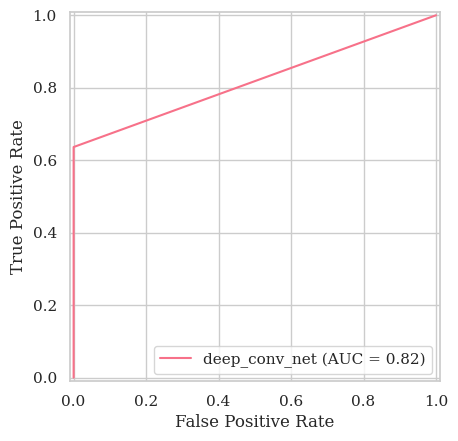

precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       1.00      0.64      0.78        11

    accuracy                           0.82        22
   macro avg       0.87      0.82      0.81        22
weighted avg       0.87      0.82      0.81        22

Precision:  0.8666666666666667

Recall:  0.8181818181818181

F1:  0.811965811965812

Accuracy:  0.8181818181818182

Balanced Accuracy:  0.8181818181818181

ROC AUC:  0.834710743801653

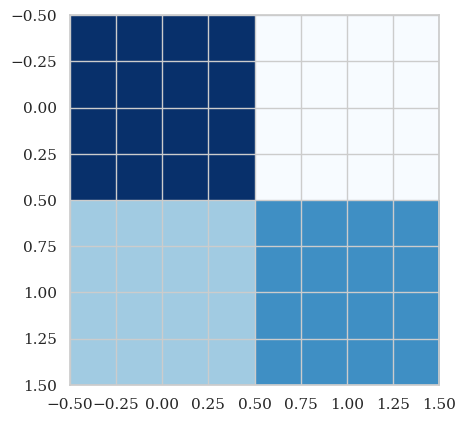

In [61]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, \
    balanced_accuracy_score, roc_curve, auc, RocCurveDisplay

y_pred = model_info["model"].predict(X_test, batch_size=model_info["batch_size"], verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_bool)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_info["model_name"])

display.plot()
plt.show()

rprint(classification_report(y_test, y_pred_bool))

rprint("Precision: ", precision_score(y_test, y_pred_bool , average="macro"))
rprint("Recall: ", recall_score(y_test, y_pred_bool , average="macro"))
rprint("F1: ", f1_score(y_test, y_pred_bool , average="macro"))

rprint("Accuracy: ", accuracy_score(y_test, y_pred_bool))
rprint("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred_bool))
rprint("ROC AUC: ", roc_auc_score(y_test, y_pred[:, 1]))

plt.imshow(confusion_matrix(y_test, y_pred_bool), cmap=plt.cm.Blues, interpolation='nearest')